In [1]:
from pathlib import Path
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
TABLES = Path("../results/tables")
files = sorted(TABLES.glob("robust_*_p*.csv"))
df = pd.concat([pd.read_csv(f).assign(file=f.name) for f in files], ignore_index=True) if files else pd.DataFrame()
df.head()

,model,p,n1,n2,rho,block,cov_kind,decay,seed,R_bh_0.05,...,fdr_lctb_0.05_B200,power_lctb_0.05_B200,t_lctb_0.1_B200,R_lctb_0.1_B200,V_lctb_0.1_B200,S_lctb_0.1_B200,fdr_lctb_0.1_B200,power_lctb_0.1_B200,wall_time_s,file
0,gaussian,250,120,120,0.25,20,block_ar1,0.6,0,0,...,0.0,0.0,4.097772,0,0,0,0.0,0.0,20.855984,robust_gaussian_p250_covblock_ar1_n120_120_rho...
1,gaussian,250,120,120,0.25,20,block_ar1,0.6,1,0,...,0.0,0.0,4.082968,0,0,0,0.0,0.0,20.888510,robust_gaussian_p250_covblock_ar1_n120_120_rho...
2,gaussian,250,120,120,0.25,20,block_ar1,0.6,2,0,...,1.0,0.0,5.063470,1,1,0,1.0,0.0,18.271425,robust_gaussian_p250_covblock_ar1_n120_120_rho...
3,gaussian,250,120,120,0.25,20,block_ar1,0.6,3,0,...,0.0,0.0,4.558839,0,0,0,0.0,0.0,20.760890,robust_gaussian_p250_covblock_ar1_n120_120_rho...
4,gaussian,250,120,120,0.25,20,block_ar1,0.6,4,0,...,0.0,0.0,4.480168,0,0,0,0.0,0.0,20.850594,robust_gaussian_p250_covblock_ar1_n120_120_rho...


In [2]:
def collect(df, prefix, yname):
    cols = [c for c in df.columns if isinstance(c, str) and c.startswith(prefix)]
    if not cols: return pd.DataFrame()
    L = df.melt(id_vars=[c for c in df.columns if c not in cols], value_vars=cols,
                var_name="metric", value_name=yname)
    L["alpha"] = L["metric"].str.extract(r'_(0\.05|0\.10)')
    L["vm"]    = L["metric"].str.extract(r'^.*_lct_([a-z_]+)_')  # cai_liu|gaussian|jackknife
    L["method"]= np.where(L["metric"].str.contains("_bh_"), "BH",
                  np.where(L["metric"].str.contains("_by_"), "BY",
                  np.where(L["metric"].str.contains("_lctb_"), "LCT-B",
                  np.where(L["metric"].str.contains("_lct_"), "LCT-N","?"))))
    return L

pwr = pd.concat([collect(df, p, "power") for p in ["power_bh_","power_by_","power_lct_","power_lctb_"]], ignore_index=True)
fdr = pd.concat([collect(df, p, "fdr")   for p in ["fdr_bh_","fdr_by_","fdr_lct_","fdr_lctb_"]],   ignore_index=True)

agg_pwr = (pwr.groupby(["model","p","cov_kind","n1","n2","rho","alpha","method","vm"], dropna=False)["power"]
             .agg(mean="mean", se=lambda x: x.std(ddof=1)/np.sqrt(len(x))).reset_index())
agg_fdr = (fdr.groupby(["model","p","cov_kind","n1","n2","rho","alpha","method","vm"], dropna=False)["fdr"]
             .agg(mean="mean", se=lambda x: x.std(ddof=1)/np.sqrt(len(x))).reset_index())
display(agg_pwr.head()); display(agg_fdr.head())


,model,p,cov_kind,n1,n2,rho,alpha,method,vm,mean,se
0,gaussian,250,block_ar1,60,60,0.2,0.05,BH,NaN,0.000000,0.000000
1,gaussian,250,block_ar1,60,60,0.2,0.05,BY,NaN,0.000000,0.000000
2,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-B,NaN,0.000000,0.000000
3,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-N,cai_liu,0.000000,0.000000
4,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-N,gaussian,0.000175,0.000175


,model,p,cov_kind,n1,n2,rho,alpha,method,vm,mean,se
0,gaussian,250,block_ar1,60,60,0.2,0.05,BH,NaN,0.033333,0.033333
1,gaussian,250,block_ar1,60,60,0.2,0.05,BY,NaN,0.000000,0.000000
2,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-B,NaN,0.000000,0.000000
3,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-N,cai_liu,0.066667,0.046321
4,gaussian,250,block_ar1,60,60,0.2,0.05,LCT-N,gaussian,0.555556,0.090878


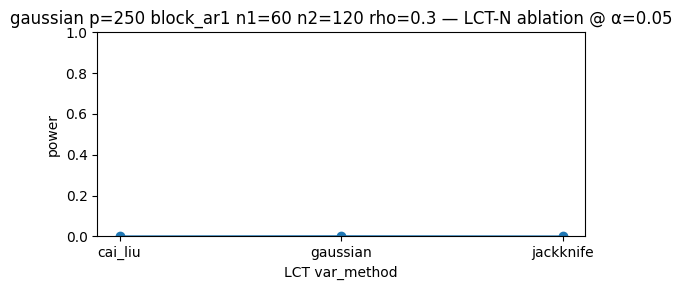

In [3]:
def plot_ablation(model, p, cov_kind, n1, n2, rho, alpha="0.05"):
    sub = agg_pwr[(agg_pwr["model"]==model)&(agg_pwr["p"]==p)&(agg_pwr["cov_kind"]==cov_kind)&
                  (agg_pwr["n1"]==n1)&(agg_pwr["n2"]==n2)&(agg_pwr["rho"]==rho)&(agg_pwr["alpha"]==alpha)]
    sub = sub[sub["method"]=="LCT-N"].copy()
    if sub.empty: 
        print("no data"); return
    order = ["cai_liu","gaussian","jackknife"]
    sub["vm"] = pd.Categorical(sub["vm"], categories=order, ordered=True)
    sub = sub.sort_values("vm")
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5.8,3.0))
    plt.errorbar(sub["vm"], sub["mean"], yerr=sub["se"], fmt="o-")
    plt.ylim(0,1); plt.ylabel("power"); plt.xlabel("LCT var_method")
    plt.title(f"{model} p={p} {cov_kind} n1={n1} n2={n2} rho={rho} — LCT-N ablation @ α={alpha}")
    plt.tight_layout(); plt.show()

plot_ablation("gaussian", 250, "block_ar1", 60, 120, 0.30, alpha="0.05")